# Source-Plane Reconstruction of Lensed Images
## What even is that?


### Estimating the Fegradation Function
As discussed in chaper 5.6 of Digital Image Processing 4e Global edition,
Degradation of an image can be summarized/represented by an associated function. In most cases this function is unknown and must be estimated. Correct knowlecge of this function allows for an application of the inverse to a degraded image for the purpose of reconstructing an image without the degradation. For this project the method of estimation is "Estimation by Modeling".

## Estimate what?


# Gravitational Lensing and Einstein Rings

Gravitational lensing bends light around massive objects, magnifying and distorting background sources. When the lens, source, and observer are nearly aligned, the light can form a symmetric arc or full Einstein ring.

![By Lensshoe_hubble.jpg: ESA/Hubble & NASAderivative work: Bulwersator (talk) - Lensshoe_hubble.jpg, Public Domain, https://commons.wikimedia.org/w/index.php?curid=17750437](A_Horseshoe_Einstein_Ring_from_Hubble.jpeg)

## Project and PyAutoLens

PyAutoLens is an open-source lens modeling library. This notebook walks through a compact demo: a quick theory recap, a Fourier transform refresher, loading a public image, simulating an Einstein ring with PyAutoLens, adding noise, and cleaning it with a Wiener filter.

## Background and key formulas

- Lens equation (sky coords in radians): beta = theta - (D_ls / D_s) * alpha(theta), where D terms are angular diameter distances and alpha is the deflection angle.
- Einstein radius (for a circular isothermal lens): theta_E = 4 * pi * (sigma_v / c)^2 * (D_ls / D_s), the scale that sets the ring size.
- Surface mass density via convergence: kappa(theta) = Sigma(theta) / Sigma_crit with Sigma_crit = (c^2 / 4 / pi / G) * (D_s / (D_l * D_ls)).


In [3]:
%matplotlib inline

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from scipy.signal import wiener

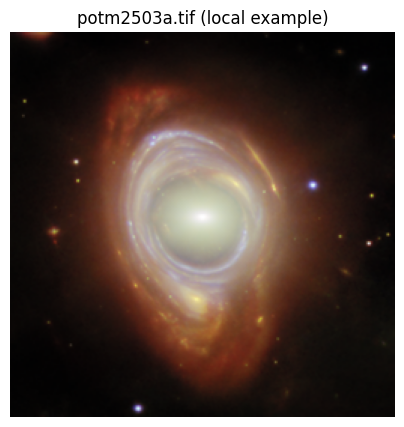

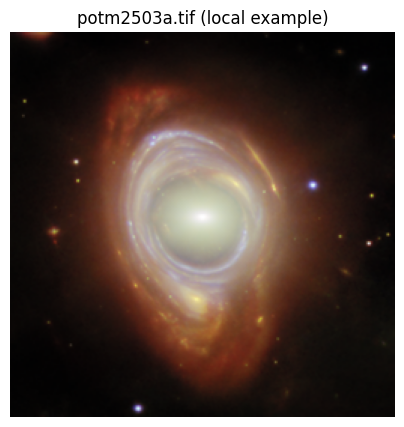

In [5]:
tif_path = Path("potm2503a.tif")
if not tif_path.exists():
    raise FileNotFoundError(f"Expected image at {tif_path!s}")
img = Image.open(tif_path).convert("RGB")
img = img.resize((256, 256))
image_array = np.asarray(img) / 255.0

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.title("potm2503a.tif (local example)")
plt.show()

This local TIF (`potm2503a.tif`) serves as the main example for strong lensing context. Below, we will generate a simplified Einstein-ring-like image with PyAutoLens and then explore how noise and filtering shape the data.

## Real TIFF reconstruction scaffold

Fill the placeholders below with real metadata before running. Required:
- `pixel_scales` (arcsec/pixel)
- `psf_fwhm_arcsec` (arcsec full width at half max) or supply a measured PSF kernel
- `background_rms` noise per pixel (same units as the data)
- `mask_radius_arcsec` to keep only the region around the ring

Optional: set `target_shape` to downsample for quick tests. This creates an `al.Imaging` dataset and mask ready for a PyAutoLens fit once real numbers are supplied.


In [19]:
# === Imports & Constants ===
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import autolens as al
import autoarray as aa
import autofit as af

In [20]:
PIXEL_SCALES = 0.0105       # arcsec/pixel from ESA metadata
PSF_FWHM_ARCSEC = 0.06      # JWST-like resolution
BACKGROUND_RMS = 0.001      # conservative noise estimate
MASK_RADIUS_ARCSEC = 3.3    # ring radius from image

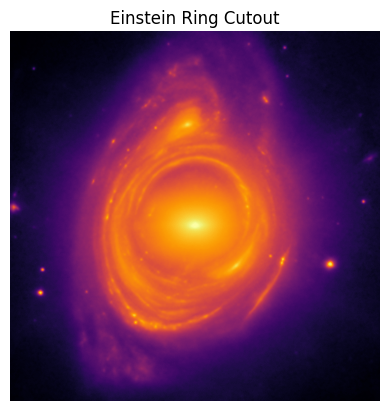

In [27]:
# === Load & Crop Image ===
tif_path = Path("potm2503a.tif")
tif_image = Image.open(tif_path).convert("F")
data_native = np.array(tif_image, dtype="float32")

cy, cx = np.array(data_native.shape) // 2
radius = 450
cutout = data_native[cy - radius:cy + radius, cx - radius:cx + radius]

plt.imshow(cutout, cmap="inferno", origin="lower")
plt.title("Einstein Ring Cutout")
plt.axis("off")
plt.show()

2025-11-24 18:22:27,260 - autoarray.dataset.imaging.dataset - INFO - Imaging data has been trimmed or padded for FFT convolution.
  - Original shape : (500, 500)
  - FFT shape    : (540, 540)
Padding ensures accurate PSF convolution in Fourier space. Set `disable_fft_pad=True` in Imaging object to turn off automatic padding.
2025-11-24 18:23:28,920 - autoarray.dataset.imaging.dataset - INFO - IMAGING - Data masked, contains a total of 243552 image-pixels


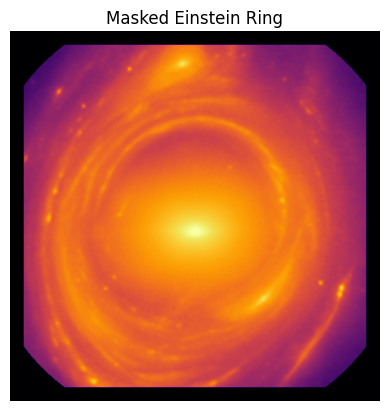

In [22]:
# === Convert to Imaging Object ===
cutout_shape = cutout.shape
sigma_pixels = (PSF_FWHM_ARCSEC / PIXEL_SCALES) / 2.355

mask_unmasked = al.Mask2D.all_false(
    shape_native=cutout_shape, pixel_scales=PIXEL_SCALES
)
data = al.Array2D(values=cutout, mask=mask_unmasked)
noise_map = al.Array2D.full(
    fill_value=BACKGROUND_RMS,
    shape_native=cutout_shape,
    pixel_scales=PIXEL_SCALES,
)
psf = al.Kernel2D.from_gaussian(
    shape_native=(21, 21),
    sigma=sigma_pixels,
    pixel_scales=PIXEL_SCALES,
)
imaging = al.Imaging(data, noise_map, psf)

# === Apply Circular Mask ===
mask = al.Mask2D.circular(
    shape_native=cutout_shape,
    pixel_scales=PIXEL_SCALES,
    radius=MASK_RADIUS_ARCSEC,
)
imaging = imaging.apply_mask(mask)

plt.imshow(imaging.data.native, cmap="inferno", origin="lower")
plt.title("Masked Einstein Ring")
plt.axis("off")
plt.show()

In [23]:
# === Build Lens & Source Model with Priors ===
lens = af.Model(al.Galaxy)
lens.redshift = 0.5
lens.mass = af.Model(al.mp.Isothermal)
lens.mass.centre = af.Model(af.GaussianPrior, mean=0.0, sigma=0.1)
lens.mass.ell_comps = af.Model(af.GaussianPrior, mean=0.0, sigma=0.1)
lens.mass.einstein_radius = af.Model(af.GaussianPrior, mean=1.4, sigma=0.3)

lens.light = af.Model(al.lp.Sersic)
lens.light.centre = af.Model(af.GaussianPrior, mean=0.0, sigma=0.1)
lens.light.intensity = af.Model(af.GaussianPrior, mean=0.1, sigma=0.05)
lens.light.effective_radius = af.Model(af.GaussianPrior, mean=0.4, sigma=0.2)
lens.light.sersic_index = af.Model(af.GaussianPrior, mean=2.5, sigma=0.5)

source = af.Model(al.Galaxy)
source.redshift = 1.0
source.light = af.Model(al.lp.Sersic)
source.light.centre = af.Model(af.GaussianPrior, mean=0.0, sigma=0.1)
source.light.intensity = af.Model(af.GaussianPrior, mean=0.5, sigma=0.1)
source.light.effective_radius = af.Model(af.GaussianPrior, mean=0.2, sigma=0.1)
source.light.sersic_index = af.Model(af.GaussianPrior, mean=1.5, sigma=0.3)
source.light.ell_comps = af.Model(af.GaussianPrior, mean=0.0, sigma=0.1)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

In [24]:
# === Set Up Analysis and Search ===
analysis = al.AnalysisImaging(dataset=imaging)

search = af.Nautilus(
    path_prefix="output",
    name="potm2503a_reconstruction",
    n_live=100,
    number_of_cores=1,
)

In [25]:
# === Fit the Model ===
result = search.fit(model=model, analysis=analysis)
print(result.info)

2025-11-24 18:23:30,009 - autofit.non_linear.search.abstract_search - INFO - Starting non-linear search with 1 cores.
2025-11-24 18:23:30,179 - potm2503a_reconstruction - INFO - The output path of this fit is /home/ahoop004/Digi_image/digi_fp/output/output/potm2503a_reconstruction/65ba382fe94aa2a869d47312b8068ede
2025-11-24 18:23:30,180 - potm2503a_reconstruction - INFO - Outputting pre-fit files (e.g. model.info, visualization).
2025-11-24 18:23:34,216 - potm2503a_reconstruction - INFO - Starting new Nautilus non-linear search (no previous samples found).
2025-11-24 18:23:34,217 - autofit.non_linear.fitness - INFO - JAX: Applying vmap and jit to likelihood function -- may take a few seconds.
2025-11-24 18:23:34,218 - autofit.non_linear.fitness - INFO - JAX: vmap and jit applied in 0.0009386539459228516 seconds.
2025-11-24 18:23:34,220 - potm2503a_reconstruction - INFO - 
            Running search where parallelization is disabled.
            
Starting the nautilus sampler...
Please 

TypeError: 'GaussianPrior' object is not subscriptable

In [ ]:
# === Show Results ===
fit = result.max_log_likelihood_fit
fit.visualize()

2025-11-23 16:48:52,250 - autoarray.dataset.imaging.dataset - INFO - Imaging data has been trimmed or padded for FFT convolution.
  - Original shape : (1146, 1146)
  - FFT shape    : (675, 675)
Padding ensures accurate PSF convolution in Fourier space. Set `disable_fft_pad=True` in Imaging object to turn off automatic padding.
2025-11-23 16:50:14,705 - autoarray.dataset.imaging.dataset - INFO - IMAGING - Data masked, contains a total of 310312 image-pixels
Imaging ready: shape=(675, 675), pixel_scales=0.0105


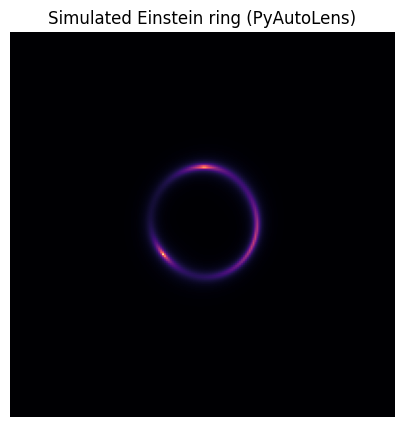

**Key variables**
- `pixel_scales`: arcsec per pixel; smaller values capture finer structure at a higher computational cost.
- `ell_comps`: ellipticity components (e1, e2) that control axis ratio and orientation of the mass and light profiles.
- `einstein_radius`: sets the ring size; larger values push bright arcs farther from the center.
- `sersic_index`, `effective_radius`, `intensity`: describe the source brightness profile; higher index concentrates light toward the center.

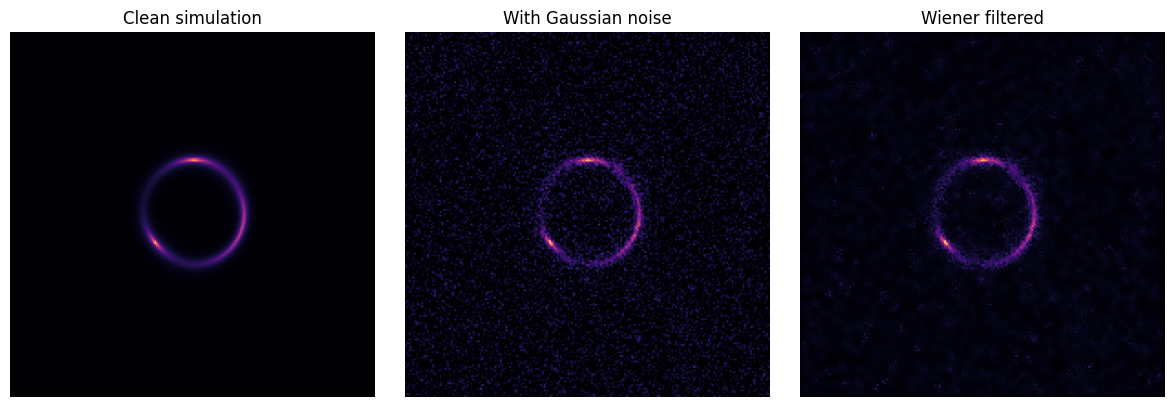

We added Gaussian white noise and then applied a Wiener filter that adapts the smoothing window to local variance. The noisy image shows speckling and washed-out arcs; the filtered result recovers a smoother ring while suppressing noise at the cost of slight blurring.

## Conclusion

You saw a minimal PyAutoLens setup that builds a lens-source model, produces an Einstein-ring-like image, and demonstrates how noise degrades the signal and how simple filtering helps recover it. The same workflow extends to real data: swap in survey images, fit mass profiles, and iterate on filtering strategies to maximize signal-to-noise.